Estimated power-law exponent (slope): -0.791


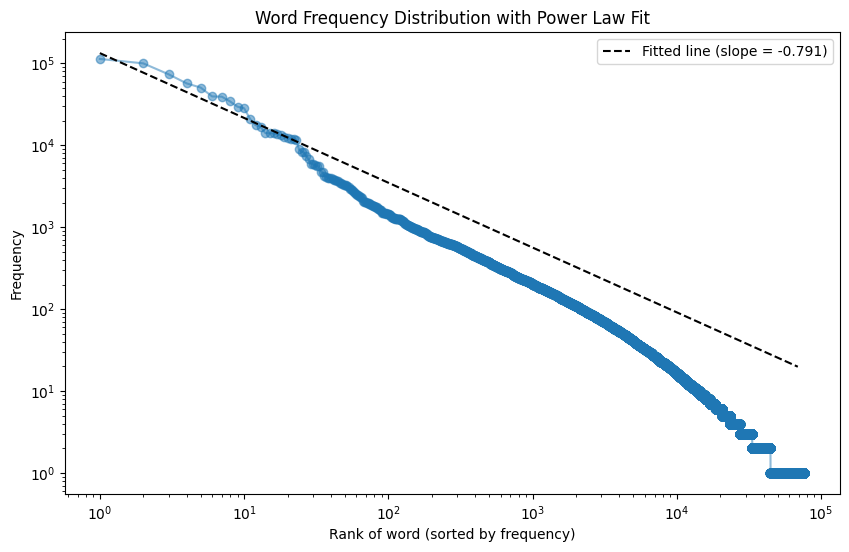

In [17]:
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset
import numpy as np

# WikiTextデータセットのロード
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

# 単語頻度のカウント
word_counts = Counter()
for sentence in dataset['text']:
    words = sentence.split()
    word_counts.update(words)

# 単語を頻度順にソート
sorted_word_counts = sorted(word_counts.values(), reverse=True)

# 頻度順にソートした順位（ランク）
ranks = np.arange(1, len(sorted_word_counts) + 1)

# 両対数スケールのプロット
plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_word_counts, marker="o", linestyle="-", alpha=0.5)


# フィットした直線をプロット
plt.loglog(ranks[:bulk], np.exp(intercept) * ranks[:bulk] ** slope, 'k--', label=f"Fitted line (slope = {slope:.3f})")

# グラフの装飾
plt.title("Word Frequency Distribution with Power Law Fit")
plt.xlabel("Rank of word (sorted by frequency)")
plt.ylabel("Frequency")
plt.legend()

# 冪指数（傾き）の表示
print(f"Estimated power-law exponent (slope): {slope:.3f}")

plt.show()

